In [1]:
%load_ext autoreload
%matplotlib inline

# Anomaly Detection Evaluation

In [2]:
import os, sys
import numpy as np
import pandas as pd
from IPython.display import display
sys.path.append(os.path.abspath(os.path.join('..')))

import plot.anomalies
from database.CERNMongoClient import CERNMongoClient
from anomaly_detection import GMM
from evaluation import evaluation, segmentation
from feature_extraction import feature_extraction, preprocessing

db = CERNMongoClient()

# auto-load changes in imported modules
%autoreload 2

In [3]:
# B1, 30min
B1_30 = feature_extraction.load_features_from_file("features_b1_sw-30min*")
B1_30_s = preprocessing.scale_robust(B1_30)

# B2, 30min
B2_30 = feature_extraction.load_features_from_file("features_b2_sw-30min*")
B2_30_s = preprocessing.scale_robust(B2_30)

labels = db.query_elogbook_anomalies()
ELB = db.query_elogbook()

Loading file '/home/n/master-thesis/src/../data-cern/features_b1_sw-30min*'.
File not found, loading '/home/n/master-thesis/src/../data-cern/features_b1_sw-30min_2018-02-26.csv' instead.
Loading file '/home/n/master-thesis/src/../data-cern/features_b2_sw-30min*'.
File not found, loading '/home/n/master-thesis/src/../data-cern/features_b2_sw-30min_2018-02-26.csv' instead.
Fetching data for pattern MKI.ELOGBOOK_tagged from 2016-04-16 00:00:00.000000 to 2016-09-14 00:00:00.000000
Fetching data for MKI.ELOGBOOK_tagged
Fetching data for pattern MKI.ELOGBOOK_tagged from 2016-04-16 00:00:00.000000 to 2016-09-14 00:00:00.000000
Fetching data for MKI.ELOGBOOK_tagged


## Prediction

In [4]:
clf_B1 = GMM.GMM(n_components=6, covariance_type='tied')
B1_scored = clf_B1.fit_and_append_scores(B1_30_s)

clf_B2 = GMM.GMM(n_components=6, covariance_type='tied')
B2_scored = clf_B2.fit_and_append_scores(B2_30_s)

## Evaluation

In [5]:
amounts_of_anomalies = [200, 250, 500, 750, 1000]
segments_lists_B1 = list(segmentation.generate_multiple_segments(B1_scored, amounts_of_anomalies))
segments_lists_B2 = list(segmentation.generate_multiple_segments(B2_scored, amounts_of_anomalies))

In [6]:
all_prediction_stats = []

for segment_B1, segment_B2 in zip(segments_lists_B1, segments_lists_B2):
    all_prediction_stats.append(evaluation.count_predictions_precision_recall(ELB, segment_B1, segment_B2))

/home/n/master-thesis/src/evaluation/evaluation.py:109: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  label_totals.sortlevel([0, 1], ascending=True, inplace=True)
/home/n/master-thesis/src/evaluation/evaluation.py:163: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  table.sortlevel([0, 1], ascending=True, inplace=True)
/home/n/master-thesis/src/evaluation/evaluation.py:109: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  label_totals.sortlevel([0, 1], ascending=True, inplace=True)
/home/n/master-thesis/src/evaluation/evaluation.py:163: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  table.sortlevel([0, 1], ascending=True, inplace=True)


In [7]:
all_prediction_stats[-1]

labels  predictions near labels  predictions  precision  \
BEAM TAG                                                                     
1    anomaly            9                        7          110   0.245455   
     fault              4                        3            0   0.000000   
     info              26                       13            0   0.000000   
     intervention       9                        3            0   0.000000   
     research           1                        1            0   0.000000   
2    anomaly            7                        4          120   0.175000   
     fault             11                        4            0   0.000000   
     info              21                       11            0   0.000000   
     intervention      10                        1            0   0.000000   
     research           2                        1            0   0.000000   

                     recall  
BEAM TAG                     
1    anomaly       0.777778  
     fault         0.750000  
     info          0.500000  
     intervention  0.333333  
     research      1.000000  
2    anomaly       0.571429  
     fault         0.363636  
     info          0.523810  
     intervention  0.100000  
     research      0.500000

In [8]:
for i, size in enumerate(amounts_of_anomalies):
    table = evaluation.labels_vs_segments_beams(labels, segments_lists_B1[i], segments_lists_B2[i])
    
    evaluation.print_labels_vs_segments_stats(size, segments_lists_B1[i], segments_lists_B2[i], table)
    display(evaluation.apply_style_labels_vs_segments(table))
    display(all_prediction_stats[i])

Anomalies used: 200
Anomalies in segments for B1: 200
Anomalies in segments for B2: 200
Segments in B1: 78
Segments in B2: 83
Segments for B1 that lie near anomaly labels:  6.0
Segments for B2 that lie near anomaly labels:  8.0
Anomalies in segments for B1 that lie near anomaly labels:  11.0
Anomalies in segments for B2 that lie near anomaly labels:  23.0


labels  predictions near labels  predictions  precision  \
BEAM TAG                                                                     
1    anomaly            9                      4.0         78.0   0.217949   
     fault              4                      3.0          0.0   0.000000   
     info              26                      7.0          0.0   0.000000   
     intervention       9                      2.0          0.0   0.000000   
     research           1                      1.0          0.0   0.000000   
2    anomaly            7                      3.0         83.0   0.156627   
     fault             11                      1.0          0.0   0.000000   
     info              21                      8.0          0.0   0.000000   
     intervention      10                      1.0          0.0   0.000000   
     research           2                      0.0          0.0   0.000000   

                     recall  
BEAM TAG                     
1    anomaly       0.444444  
     fault         0.750000  
     info          0.269231  
     intervention  0.222222  
     research      1.000000  
2    anomaly       0.428571  
     fault         0.090909  
     info          0.380952  
     intervention  0.100000  
     research      0.000000

Anomalies used: 250
Anomalies in segments for B1: 250
Anomalies in segments for B2: 249
Segments in B1: 83
Segments in B2: 90
Segments for B1 that lie near anomaly labels:  7.0
Segments for B2 that lie near anomaly labels:  8.0
Anomalies in segments for B1 that lie near anomaly labels:  17.0
Anomalies in segments for B2 that lie near anomaly labels:  26.0


labels  predictions near labels  predictions  precision  \
BEAM TAG                                                                     
1    anomaly            9                      5.0         83.0   0.253012   
     fault              4                      3.0          0.0   0.000000   
     info              26                     10.0          0.0   0.000000   
     intervention       9                      2.0          0.0   0.000000   
     research           1                      1.0          0.0   0.000000   
2    anomaly            7                      3.0         90.0   0.166667   
     fault             11                      3.0          0.0   0.000000   
     info              21                      8.0          0.0   0.000000   
     intervention      10                      1.0          0.0   0.000000   
     research           2                      0.0          0.0   0.000000   

                     recall  
BEAM TAG                     
1    anomaly       0.555556  
     fault         0.750000  
     info          0.384615  
     intervention  0.222222  
     research      1.000000  
2    anomaly       0.428571  
     fault         0.272727  
     info          0.380952  
     intervention  0.100000  
     research      0.000000

Anomalies used: 500
Anomalies in segments for B1: 465
Anomalies in segments for B2: 495
Segments in B1: 95
Segments in B2: 114
Segments for B1 that lie near anomaly labels:  12.0
Segments for B2 that lie near anomaly labels:  10.0
Anomalies in segments for B1 that lie near anomaly labels:  126.0
Anomalies in segments for B2 that lie near anomaly labels:  47.0


labels  predictions near labels  predictions  precision  \
BEAM TAG                                                                     
1    anomaly            9                        7           95   0.252632   
     fault              4                        3            0   0.000000   
     info              26                       11            0   0.000000   
     intervention       9                        2            0   0.000000   
     research           1                        1            0   0.000000   
2    anomaly            7                        4          114   0.184211   
     fault             11                        4            0   0.000000   
     info              21                       11            0   0.000000   
     intervention      10                        1            0   0.000000   
     research           2                        1            0   0.000000   

                     recall  
BEAM TAG                     
1    anomaly       0.777778  
     fault         0.750000  
     info          0.423077  
     intervention  0.222222  
     research      1.000000  
2    anomaly       0.571429  
     fault         0.363636  
     info          0.523810  
     intervention  0.100000  
     research      0.500000

Anomalies used: 750
Anomalies in segments for B1: 664
Anomalies in segments for B2: 717
Segments in B1: 105
Segments in B2: 118
Segments for B1 that lie near anomaly labels:  12.0
Segments for B2 that lie near anomaly labels:  11.0
Anomalies in segments for B1 that lie near anomaly labels:  193.0
Anomalies in segments for B2 that lie near anomaly labels:  176.0


labels  predictions near labels  predictions  precision  \
BEAM TAG                                                                     
1    anomaly            9                        7          105   0.257143   
     fault              4                        3            0   0.000000   
     info              26                       13            0   0.000000   
     intervention       9                        3            0   0.000000   
     research           1                        1            0   0.000000   
2    anomaly            7                        4          118   0.177966   
     fault             11                        4            0   0.000000   
     info              21                       11            0   0.000000   
     intervention      10                        1            0   0.000000   
     research           2                        1            0   0.000000   

                     recall  
BEAM TAG                     
1    anomaly       0.777778  
     fault         0.750000  
     info          0.500000  
     intervention  0.333333  
     research      1.000000  
2    anomaly       0.571429  
     fault         0.363636  
     info          0.523810  
     intervention  0.100000  
     research      0.500000

Anomalies used: 1000
Anomalies in segments for B1: 877
Anomalies in segments for B2: 943
Segments in B1: 110
Segments in B2: 120
Segments for B1 that lie near anomaly labels:  12.0
Segments for B2 that lie near anomaly labels:  13.0
Anomalies in segments for B1 that lie near anomaly labels:  335.0
Anomalies in segments for B2 that lie near anomaly labels:  235.0


labels  predictions near labels  predictions  precision  \
BEAM TAG                                                                     
1    anomaly            9                        7          110   0.245455   
     fault              4                        3            0   0.000000   
     info              26                       13            0   0.000000   
     intervention       9                        3            0   0.000000   
     research           1                        1            0   0.000000   
2    anomaly            7                        4          120   0.175000   
     fault             11                        4            0   0.000000   
     info              21                       11            0   0.000000   
     intervention      10                        1            0   0.000000   
     research           2                        1            0   0.000000   

                     recall  
BEAM TAG                     
1    anomaly       0.777778  
     fault         0.750000  
     info          0.500000  
     intervention  0.333333  
     research      1.000000  
2    anomaly       0.571429  
     fault         0.363636  
     info          0.523810  
     intervention  0.100000  
     research      0.500000

Remove 'info' label stats for summary stats

In [17]:
all_stats = [a.query("TAG != 'info'") for a in all_prediction_stats]

In [18]:
stats = evaluation.summary_precision_recall_df(all_stats, amounts_of_anomalies, "amount of anomalies")
evaluation.apply_style_precision_recall(stats)

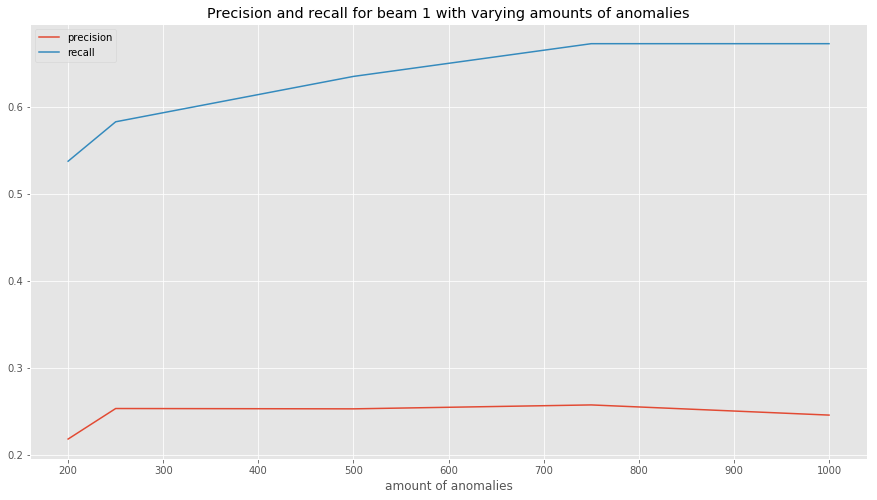

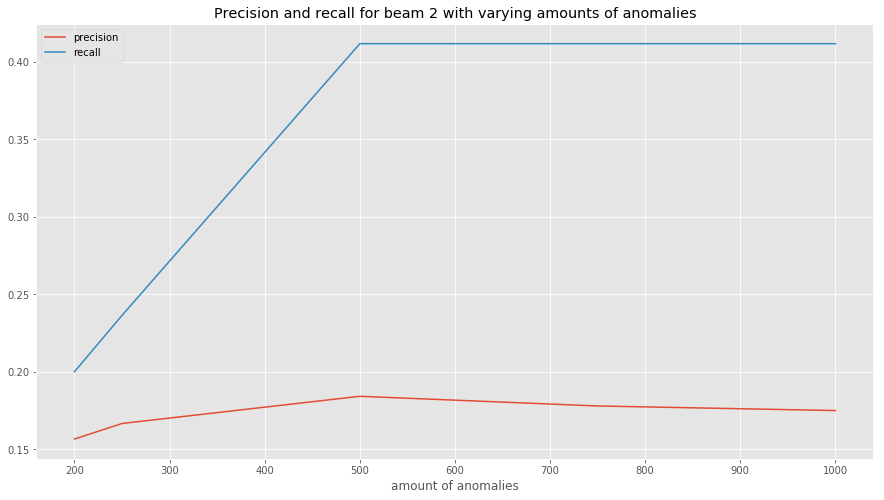

In [20]:
plot.anomalies.precision_recall_stats(stats, "amounts of anomalies")

## Visualization

In [21]:
labels_anomalies_B1 = db.query_elogbook_anomalies(beam=1)
labels_anomalies_B2 = db.query_elogbook_anomalies(beam=2)

labels_no_info_B1 = db.query_elogbook_no_info(beam=1)
labels_no_info_B2 = db.query_elogbook_no_info(beam=2)

labels_B1_all = db.query_elogbook(beam=1)

Fetching data for pattern MKI.ELOGBOOK_tagged from 2016-04-16 00:00:00.000000 to 2016-09-14 00:00:00.000000
Fetching data for MKI.ELOGBOOK_tagged
Fetching data for pattern MKI.ELOGBOOK_tagged from 2016-04-16 00:00:00.000000 to 2016-09-14 00:00:00.000000
Fetching data for MKI.ELOGBOOK_tagged
Fetching data for pattern MKI.ELOGBOOK_tagged from 2016-04-16 00:00:00.000000 to 2016-09-14 00:00:00.000000
Fetching data for MKI.ELOGBOOK_tagged
Fetching data for pattern MKI.ELOGBOOK_tagged from 2016-04-16 00:00:00.000000 to 2016-09-14 00:00:00.000000
Fetching data for MKI.ELOGBOOK_tagged
Fetching data for pattern MKI.ELOGBOOK_tagged from 2016-04-16 00:00:00.000000 to 2016-09-14 00:00:00.000000
Fetching data for MKI.ELOGBOOK_tagged


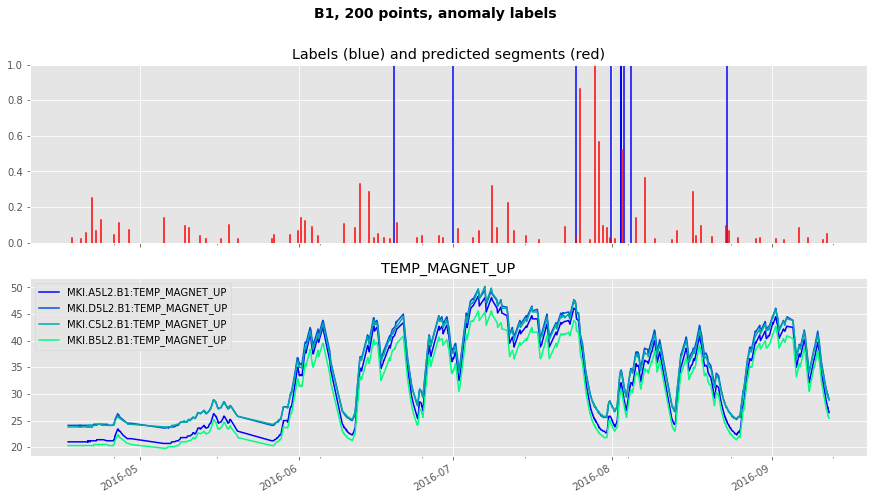

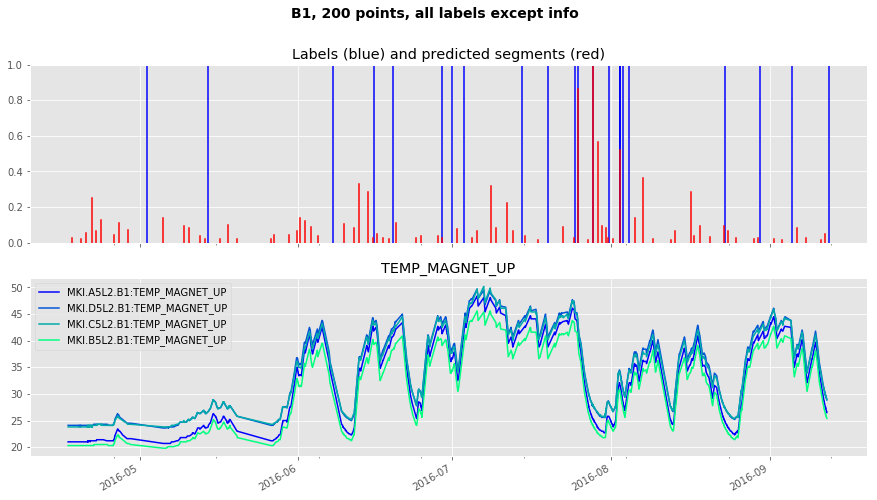

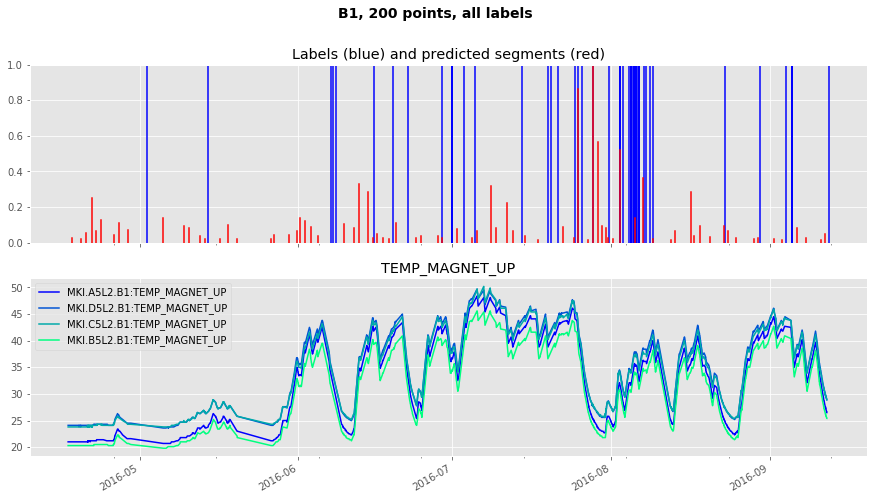

In [22]:
plot.anomalies.timeseries_segments(B1_30, "TEMP_MAGNET_UP", segments_lists_B1[0], labels_anomalies_B1, 'B1, 200 points, anomaly labels')
plot.anomalies.timeseries_segments(B1_30, "TEMP_MAGNET_UP", segments_lists_B1[0], labels_no_info_B1, 'B1, 200 points, all labels except info')
plot.anomalies.timeseries_segments(B1_30, "TEMP_MAGNET_UP", segments_lists_B1[0], labels_B1_all, 'B1, 200 points, all labels')

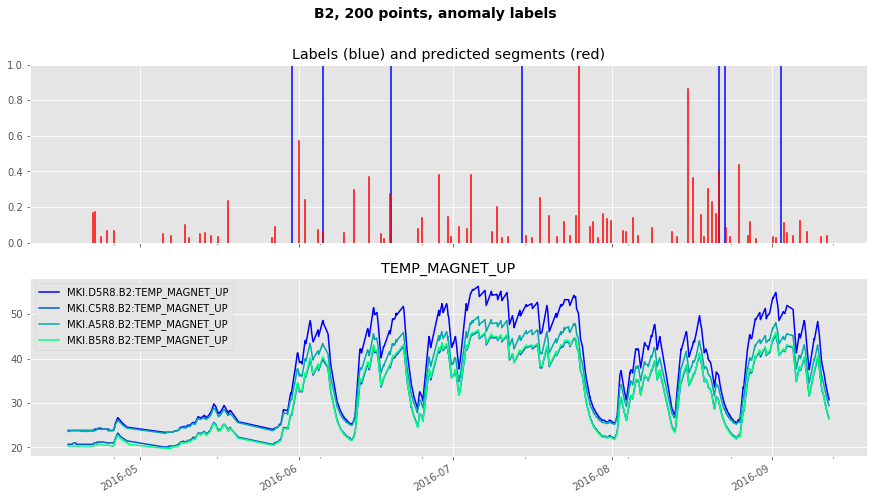

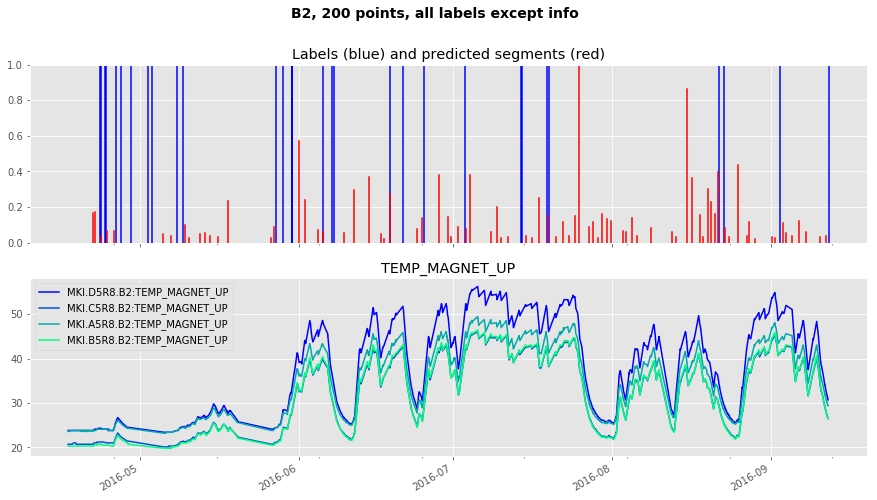

In [23]:
plot.anomalies.timeseries_segments(B2_30, "TEMP_MAGNET_UP", segments_lists_B2[0], labels_anomalies_B2, 'B2, 200 points, anomaly labels')
plot.anomalies.timeseries_segments(B2_30, "TEMP_MAGNET_UP", segments_lists_B2[0], labels_no_info_B2, 'B2, 200 points, all labels except info')

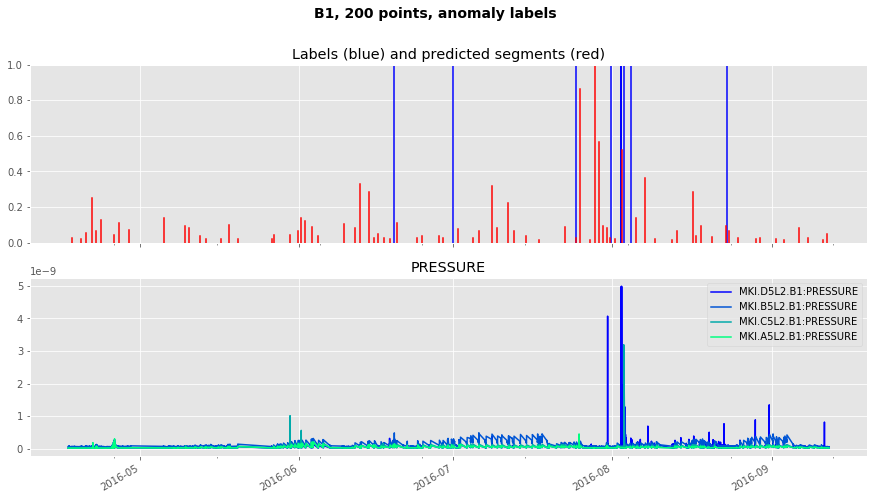

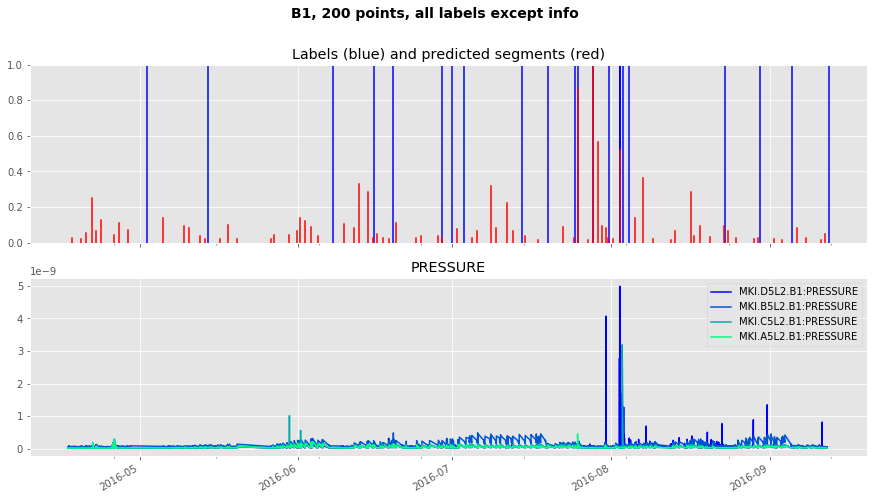

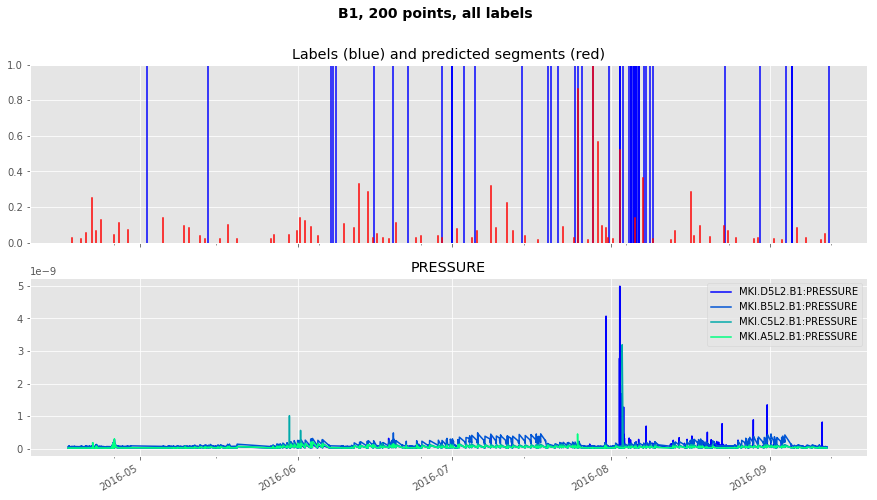

In [24]:
plot.anomalies.timeseries_segments(B1_30, "PRESSURE", segments_lists_B1[0], labels_anomalies_B1, 'B1, 200 points, anomaly labels')
plot.anomalies.timeseries_segments(B1_30, "PRESSURE", segments_lists_B1[0], labels_no_info_B1, 'B1, 200 points, all labels except info')
plot.anomalies.timeseries_segments(B1_30, "PRESSURE", segments_lists_B1[0], labels_B1_all, 'B1, 200 points, all labels')

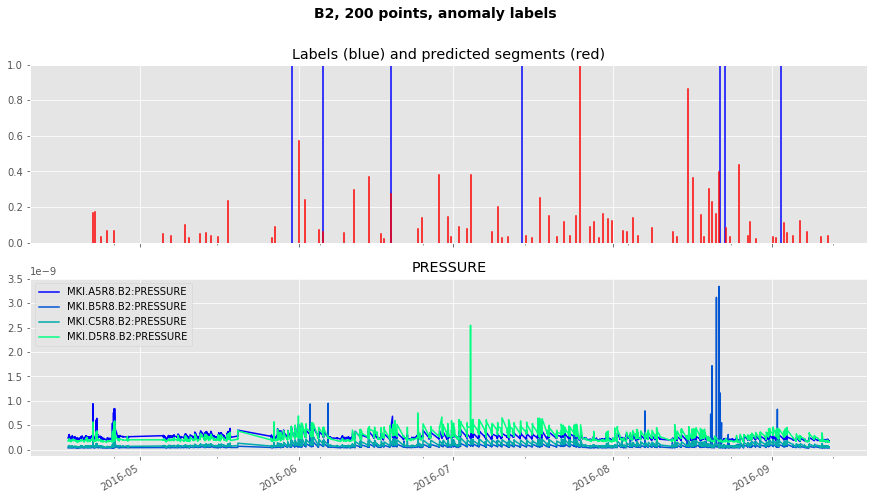

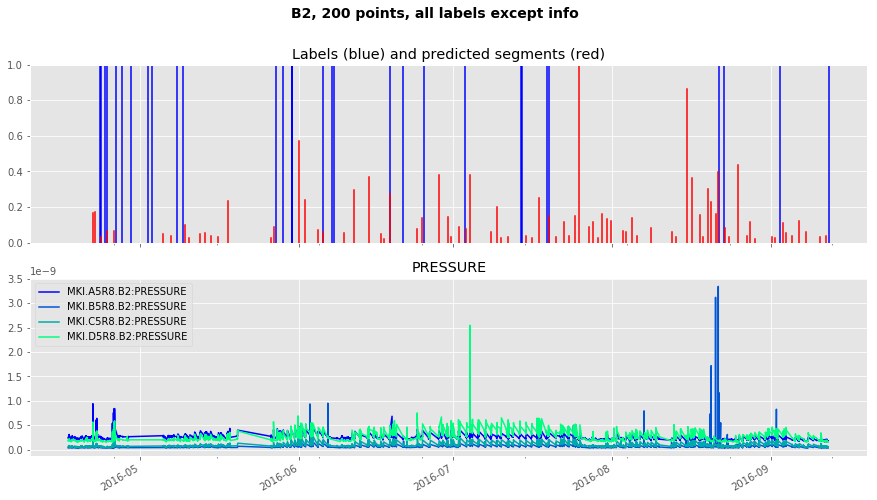

In [25]:
plot.anomalies.timeseries_segments(B2_30, "PRESSURE", segments_lists_B2[0], labels_anomalies_B2, 'B2, 200 points, anomaly labels')
plot.anomalies.timeseries_segments(B2_30, "PRESSURE", segments_lists_B2[0], labels_no_info_B2, 'B2, 200 points, all labels except info')